In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
# https://www.kaggle.com/competitions/playground-series-s6e1/data?select=train.csv

# 1. Load the datasets
folder_path_local = "../input/playground-series-s6e1/"
folder_path_remote = "https://kagglecsv.netlify.app/input/playground-series-s6e1/"
folder_path = folder_path_local if os.path.exists(folder_path_local) else folder_path_remote  # choose local if available, else remote
train_data = pd.read_csv(folder_path + 'train.csv')
test_data = pd.read_csv(folder_path + 'test.csv')
print("Datasets loaded successfully.")

Datasets loaded successfully.


In [4]:
# 2. Check column names for both train and test data
print("Train Data Columns:", train_data.columns)
print("Test Data Columns:", test_data.columns)

Train Data Columns: Index(['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')
Test Data Columns: Index(['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty'],
      dtype='object')


In [5]:
# 3. Identify categorical columns (ignore 'id' column)
categorical_columns = train_data.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('id', errors='ignore')  # Drop 'id' if it exists, otherwise ignore
print(f"Categorical columns: {categorical_columns}")

Categorical columns: Index(['gender', 'course', 'internet_access', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty'],
      dtype='object')


In [6]:
# 4. Convert categorical features to pandas 'category' dtype (preferred for tree models)
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
if 'id' in categorical_columns:
    categorical_columns.remove('id')
for col in categorical_columns:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')
print(f"Categorical columns converted: {categorical_columns}")

Categorical columns converted: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


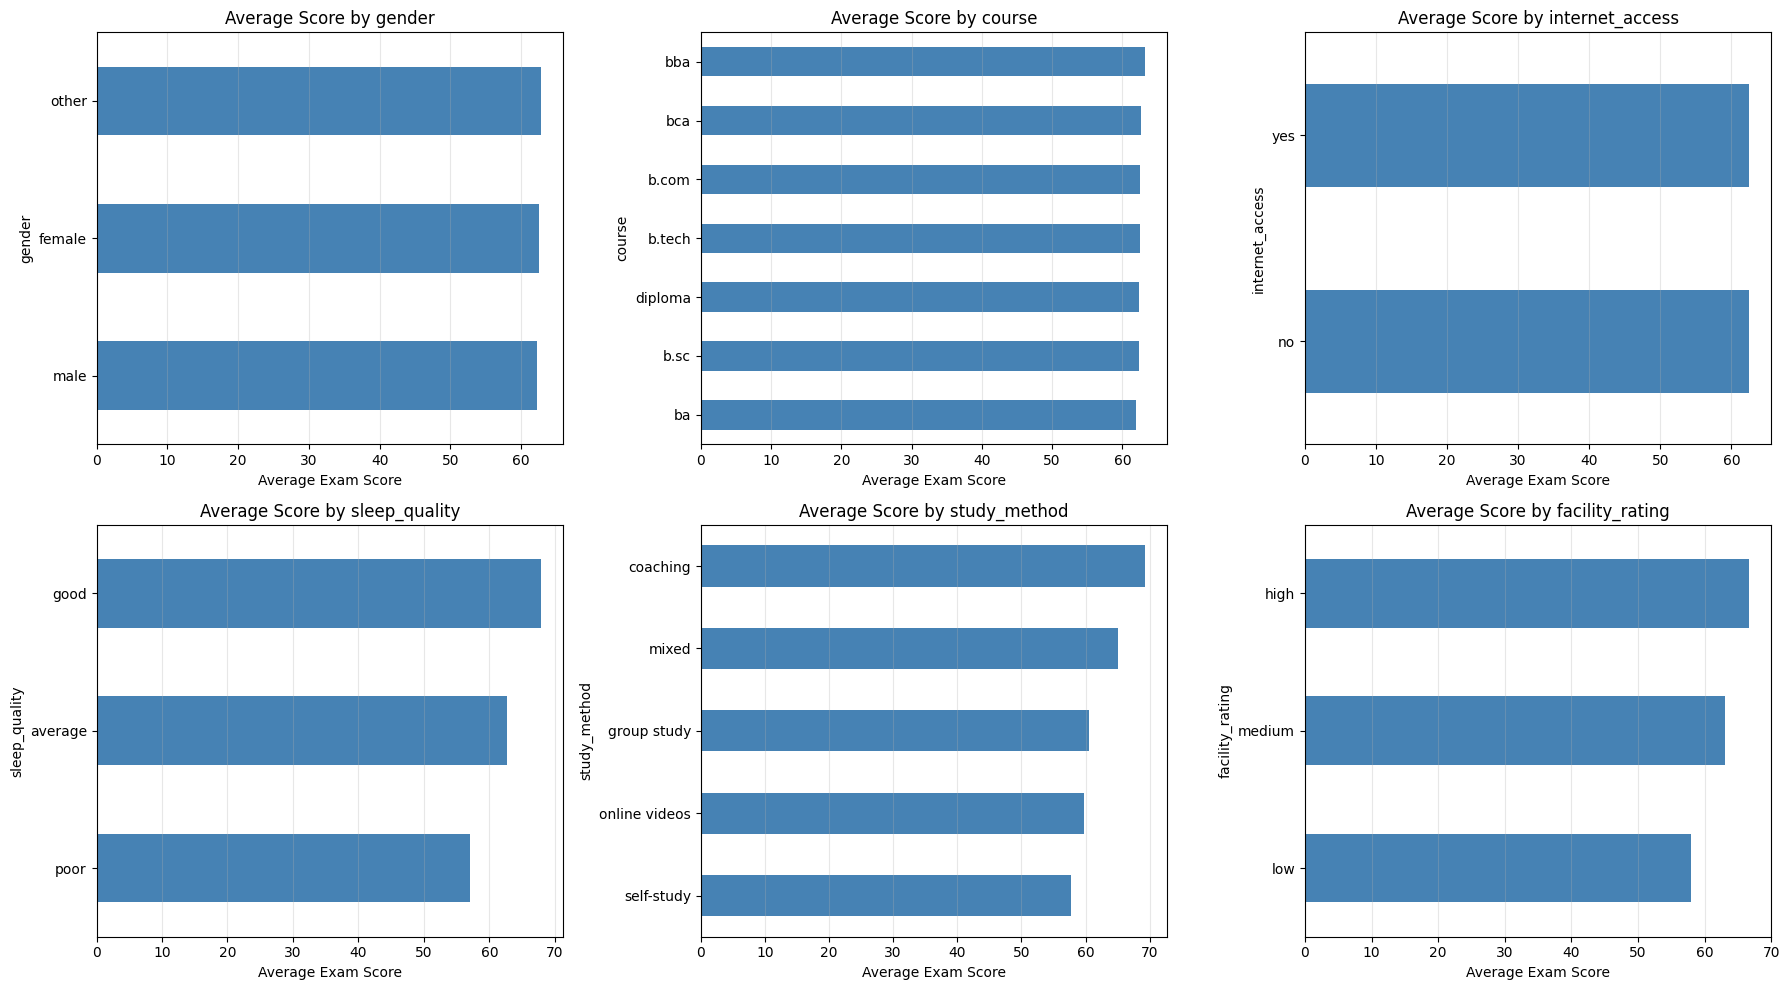

In [7]:
# Categorical features vs Exam Score
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns
categorical_cols = [col for col in categorical_cols if col != 'id']

if len(categorical_cols) > 0:
    num_cats = min(6, len(categorical_cols))  # Show up to 6 categorical features
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols[:num_cats]):
        avg_scores = train_data.groupby(col, observed=False)['exam_score'].mean().sort_values()
        avg_scores.plot(kind='barh', ax=axes[idx], color='steelblue')
        axes[idx].set_xlabel('Average Exam Score')
        axes[idx].set_title(f'Average Score by {col}')
        axes[idx].grid(alpha=0.3, axis='x')
    
    # Hide unused subplots
    for idx in range(num_cats, 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features to visualize.")

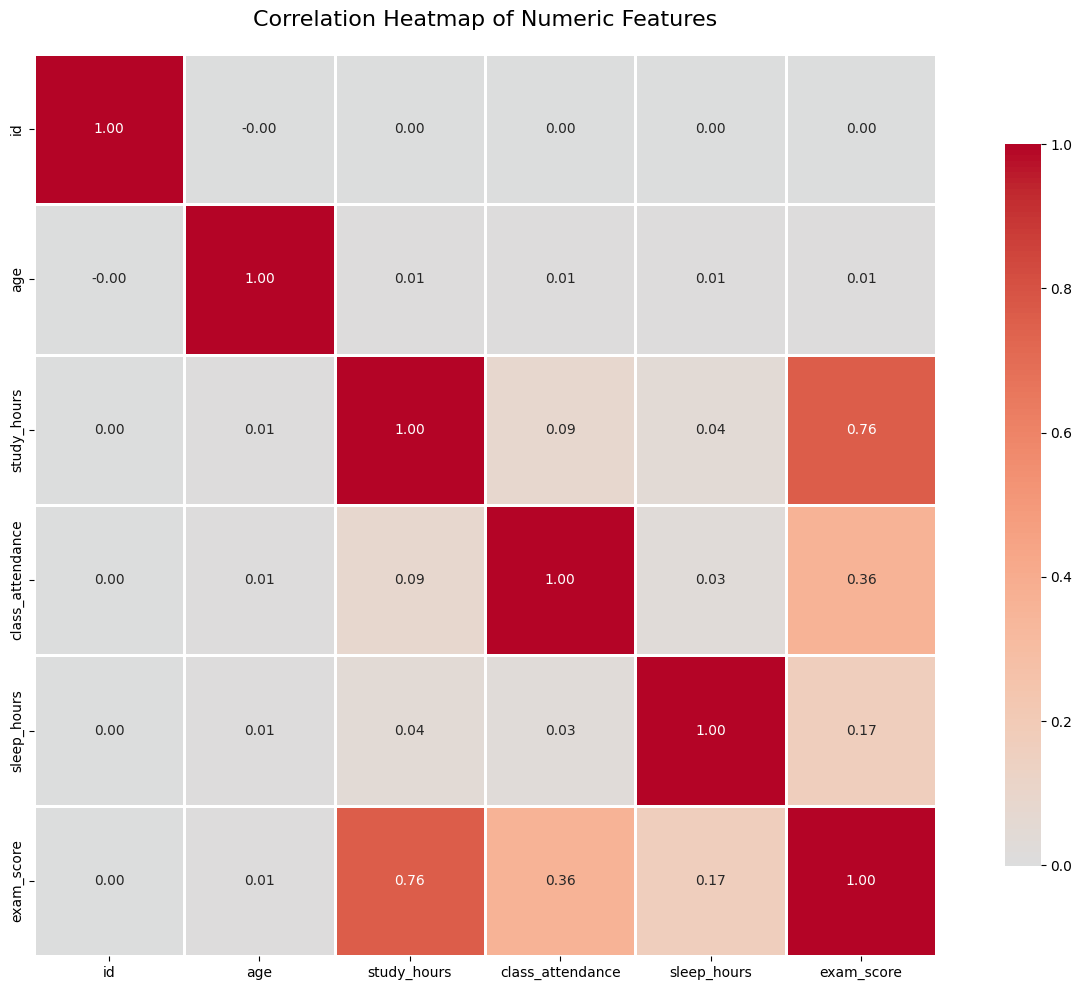


Top correlations with exam_score:
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64


In [8]:
# Correlation heatmap for numeric features
numeric_features = train_data.select_dtypes(include=[np.number]).columns
if len(numeric_features) > 1:
    plt.figure(figsize=(14, 10))
    correlation_matrix = train_data[numeric_features].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap of Numeric Features', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Show top correlations with target
    if 'exam_score' in correlation_matrix.columns:
        target_corr = correlation_matrix['exam_score'].drop('exam_score').sort_values(ascending=False)
        print("\nTop correlations with exam_score:")
        print(target_corr.head(10))

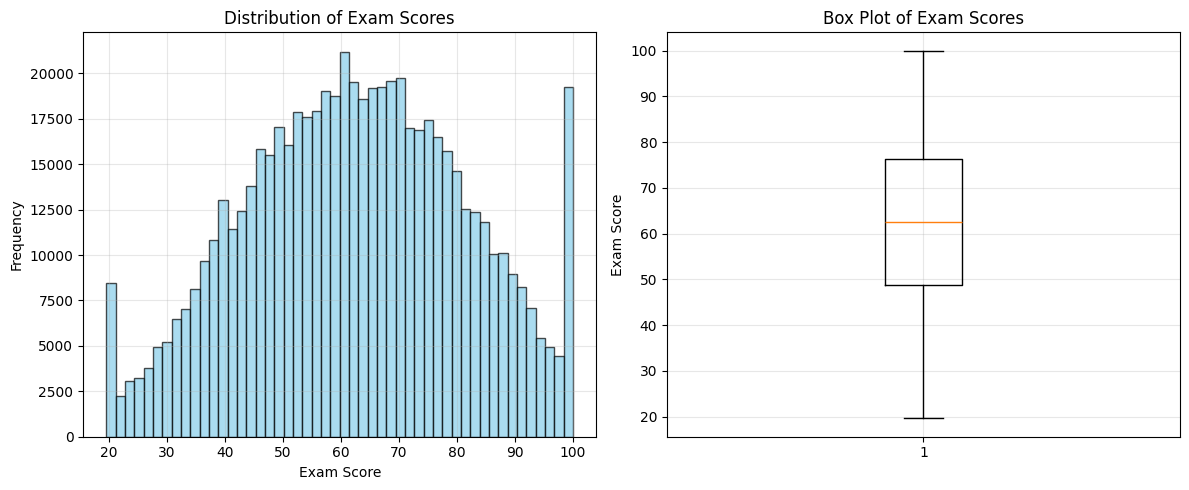

Exam Score Statistics:
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


In [9]:
# Target variable distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_data['exam_score'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.title('Distribution of Exam Scores')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(train_data['exam_score'], vert=True)
plt.ylabel('Exam Score')
plt.title('Box Plot of Exam Scores')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Exam Score Statistics:")
print(train_data['exam_score'].describe())

## Data Visualization and Exploration

In [10]:
# 5. Split data into features (X) and target (y)
if 'id' in train_data.columns:  # Check if 'id' exists before dropping it
    X = train_data.drop(columns=['id', 'exam_score'])  # Drop 'id' and 'exam_score' columns
else:
    X = train_data.drop(columns=['exam_score'])  # Only drop 'exam_score' if 'id' is not present
y = train_data['exam_score']

In [11]:
# 6. Simple imputation for numeric features (no scaling for tree models)
from sklearn.impute import SimpleImputer
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
X[num_cols] = imputer.fit_transform(X[num_cols])
# Prepare a version of the test features for later
if 'id' in test_data.columns:
    X_test = test_data.drop(columns=['id']).copy()
else:
    X_test = test_data.copy()
X_test[num_cols] = imputer.transform(X_test[num_cols])
print('Imputed numeric columns:', num_cols)

Imputed numeric columns: ['age', 'study_hours', 'class_attendance', 'sleep_hours']


In [12]:
# 6b. Feature Engineering to reduce RMSE from ~8.7 to lower values
print("Creating engineered features to improve predictions...")

# Interaction features between numeric columns
from sklearn.preprocessing import PolynomialFeatures
numeric_cols_for_interaction = X.select_dtypes(include=[np.number]).columns[:5]  # Top 5 numeric features

if len(numeric_cols_for_interaction) >= 2:
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    X_poly = poly.fit_transform(X[numeric_cols_for_interaction])
    X_test_poly = poly.transform(X_test[numeric_cols_for_interaction])
    
    # Add polynomial features
    feature_names = poly.get_feature_names_out(numeric_cols_for_interaction)
    for i, fname in enumerate(feature_names[len(numeric_cols_for_interaction):]):
        X[f'interaction_{i}'] = X_poly[:, len(numeric_cols_for_interaction) + i]
        X_test[f'interaction_{i}'] = X_test_poly[:, len(numeric_cols_for_interaction) + i]
    
    print(f"Added {len(feature_names) - len(numeric_cols_for_interaction)} interaction features")

# Statistical aggregations per categorical group (if any categorical features exist)
if len(categorical_columns) > 0:
    for cat_col in categorical_columns[:2]:  # Top 2 categorical
        if cat_col in X.columns:
            # Mean encoding - convert to float to avoid categorical assignment error
            means = train_data.groupby(cat_col, observed=False)['exam_score'].mean()
            X[f'{cat_col}_mean_target'] = X[cat_col].map(means).astype('float64').fillna(y.mean())
            X_test[f'{cat_col}_mean_target'] = X_test[cat_col].map(means).astype('float64').fillna(y.mean())
            print(f"Added mean encoding for {cat_col}")

print(f"Final feature count: {X.shape[1]} features")

Creating engineered features to improve predictions...
Added 6 interaction features
Added mean encoding for gender
Added mean encoding for course
Final feature count: 19 features


In [13]:
# 7. Train-test split (for evaluation purposes)
# NOTE: the earlier pipeline removed scaling; the actual split is performed later using the imputed DataFrame `X`
# (Old split referencing `X_scaled_df` has been removed to avoid NameError)

In [14]:
# Models: Optimized ensemble with tuned hyperparameters to minimize RMSE
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Enable all 3 models with aggressive tuning for lower RMSE
models = {

    #'CatBoost': CatBoostRegressor(iterations=7900, learning_rate=0.02, depth=8, l2_leaf_reg=5, random_state=42, verbose=0),
    #'LightGBM': LGBMRegressor(n_estimators=2000, learning_rate=0.02, max_depth=8, num_leaves=64, min_child_samples=10, random_state=42),
    # 'XGBoost': XGBRegressor(n_estimators=3000, learning_rate=0.02, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method='hist', verbosity=0)
'LightGBM':LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )}

# Determine categorical feature names (for LightGBM/CatBoost)
categorical_features = [col for col in X.columns if str(X[col].dtype) == 'category']
print('Categorical features to pass to models:', categorical_features)

Categorical features to pass to models: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [15]:
# 9. Train models and evaluate using RMSE (competition metric) with early stopping
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

trained_models = {}
best_mae = float('inf')
best_model_name = None

for name, model in models.items():
    print(f"Training {name}...")
    try:
        if name == 'LightGBM':
            # LightGBM with RMSE metric
            try:
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmse', categorical_feature=categorical_features)
            except:
                model.fit(X_train, y_train)
        elif name == 'CatBoost':
            # CatBoost with RMSE optimization
            try:
                model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=categorical_features, use_best_model=True, verbose=100)
            except TypeError:
                model.fit(X_train, y_train)
        elif name == 'XGBoost':
            # XGBoost with RMSE objective
            try:
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
            except TypeError:
                model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)
    except Exception as e:
        print(f"Error training {name}:", e)
        continue

    y_pred = model.predict(X_valid)
    rmse = root_mean_squared_error(y_valid, y_pred)
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f} (Competition Metric)")
    trained_models[name] = model
    if rmse < best_mae:
        best_mae = rmse
        best_model_name = name
    print('\n')

print(f'Best model: {best_model_name} with RMSE: {best_mae:.5f}')

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 19
[LightGBM] [Info] Start training from score 62.482335
LightGBM - MAE: 6.9915, RMSE: 8.7657 (Competition Metric)


Best model: LightGBM with RMSE: 8.76566


In [16]:
# 10. Select best model object
if not trained_models:
    raise RuntimeError('No models were successfully trained. Check training logs above for errors.')
if best_model_name is None:
    # If best_model_name wasn't set (e.g. training skipped/failed for all), pick the first trained model
    best_model_name = list(trained_models.keys())[0]
    print('Warning: best_model_name was None; defaulting to', best_model_name)
best_model = trained_models[best_model_name]
best_model_name

'LightGBM'

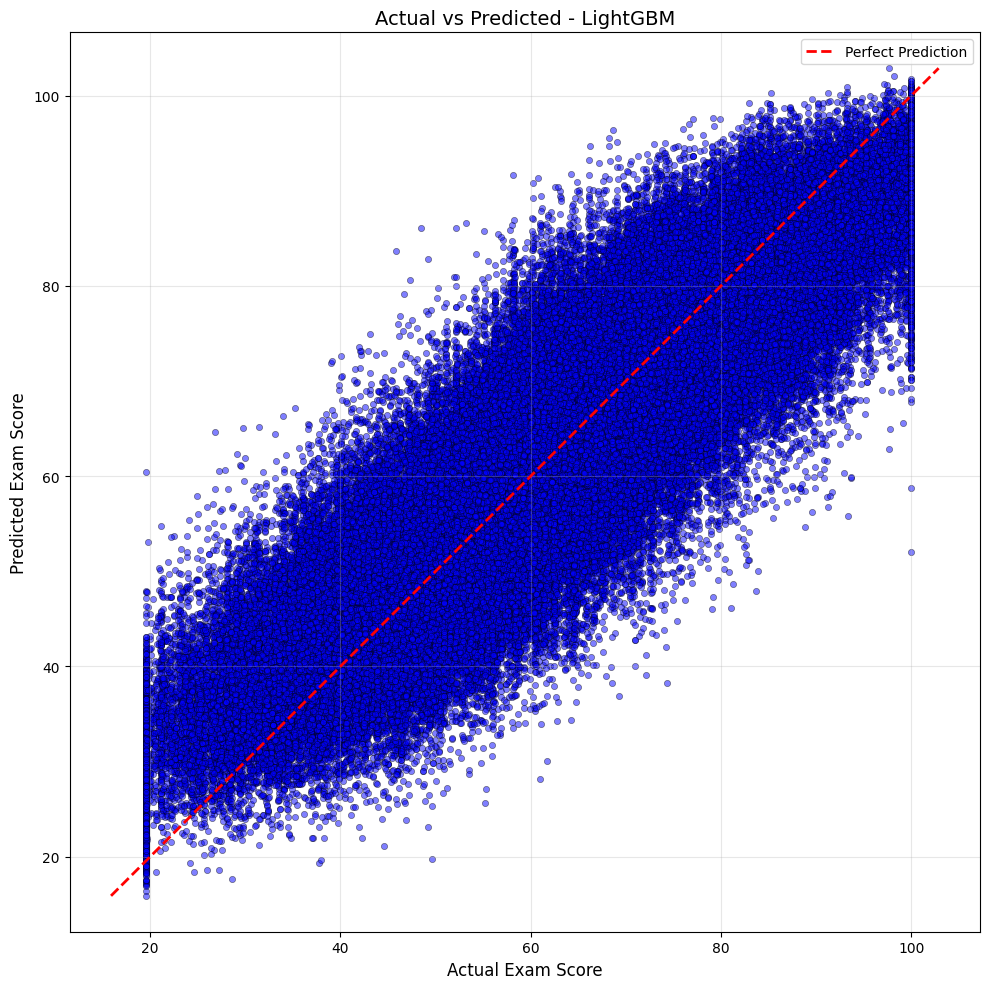

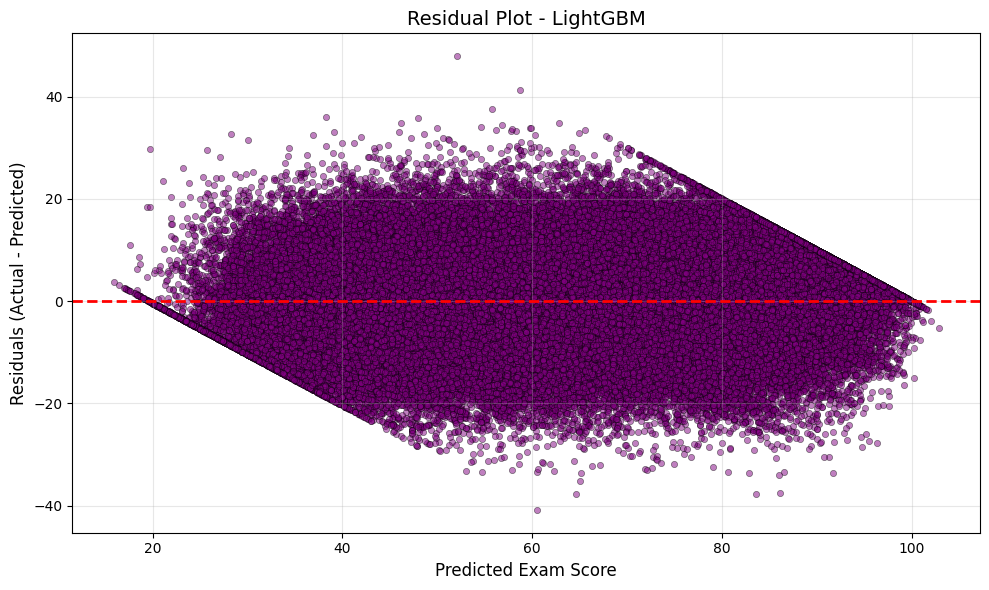

Residual Statistics:
Mean: 0.0227
Std Dev: 8.7657
Min: -40.8829
Max: 47.9535


In [17]:
# Actual vs Predicted scatter plot
if trained_models and best_model is not None:
    y_pred_valid = best_model.predict(X_valid)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y_valid, y_pred_valid, alpha=0.5, s=20, color='blue', edgecolors='k', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_valid.min(), y_pred_valid.min())
    max_val = max(y_valid.max(), y_pred_valid.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Exam Score', fontsize=12)
    plt.ylabel('Predicted Exam Score', fontsize=12)
    plt.title(f'Actual vs Predicted - {best_model_name}', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # Residual plot
    residuals = y_valid - y_pred_valid
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_valid, residuals, alpha=0.5, s=20, color='purple', edgecolors='k', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Exam Score', fontsize=12)
    plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
    plt.title(f'Residual Plot - {best_model_name}', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Residual Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std Dev: {residuals.std():.4f}")
    print(f"Min: {residuals.min():.4f}")
    print(f"Max: {residuals.max():.4f}")

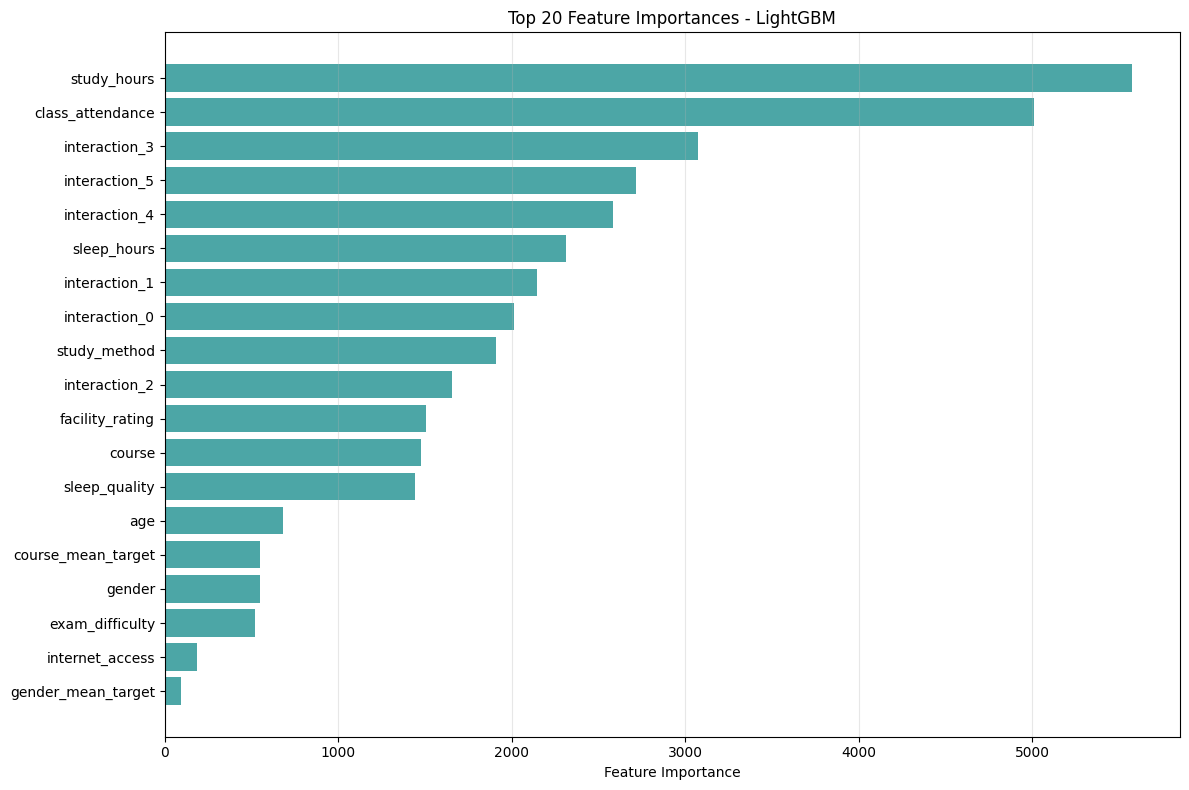

In [18]:
# Feature importance from best model
if best_model is not None:
    plt.figure(figsize=(12, 8))
    
    try:
        # Try to get feature importance
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            feature_names = X.columns
            
            # Sort by importance
            indices = np.argsort(importances)[-20:]  # Top 20 features
            
            plt.barh(range(len(indices)), importances[indices], color='teal', alpha=0.7)
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 20 Feature Importances - {best_model_name}')
            plt.grid(alpha=0.3, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print(f"{best_model_name} does not have feature_importances_ attribute")
    except Exception as e:
        print(f"Could not plot feature importance: {e}")

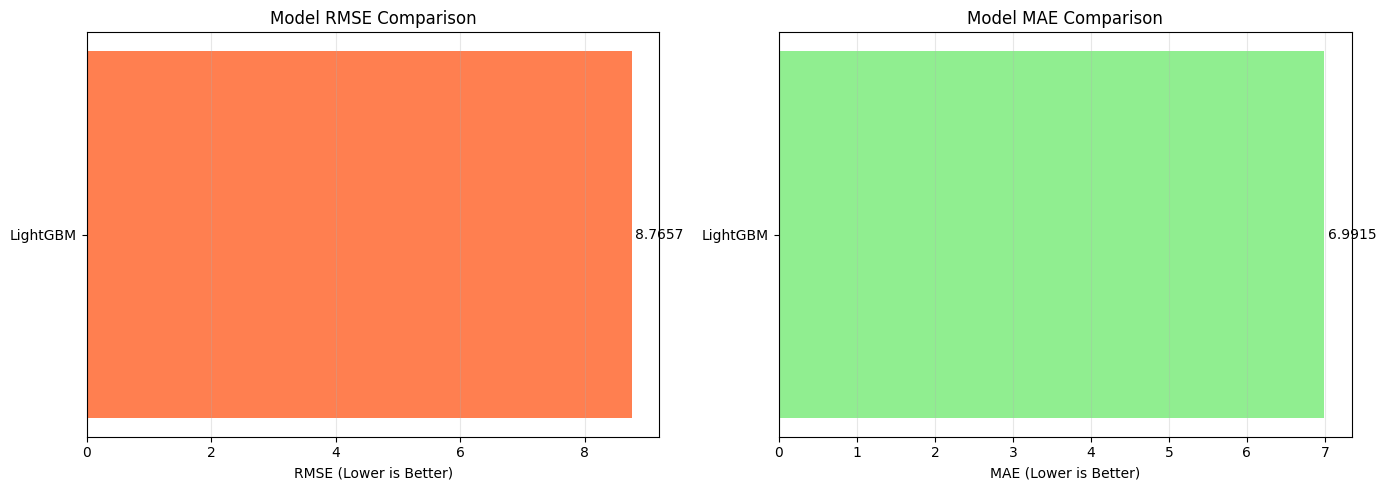

In [19]:
# Model comparison visualization
if trained_models:
    model_names = []
    rmse_scores = []
    mae_scores = []
    
    for name, model in trained_models.items():
        try:
            y_pred = model.predict(X_valid)
            rmse = root_mean_squared_error(y_valid, y_pred)
            mae = mean_absolute_error(y_valid, y_pred)
            model_names.append(name)
            rmse_scores.append(rmse)
            mae_scores.append(mae)
        except:
            pass
    
    if model_names:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # RMSE comparison
        axes[0].barh(model_names, rmse_scores, color='coral')
        axes[0].set_xlabel('RMSE (Lower is Better)')
        axes[0].set_title('Model RMSE Comparison')
        axes[0].grid(alpha=0.3, axis='x')
        for i, v in enumerate(rmse_scores):
            axes[0].text(v + 0.05, i, f'{v:.4f}', va='center')
        
        # MAE comparison
        axes[1].barh(model_names, mae_scores, color='lightgreen')
        axes[1].set_xlabel('MAE (Lower is Better)')
        axes[1].set_title('Model MAE Comparison')
        axes[1].grid(alpha=0.3, axis='x')
        for i, v in enumerate(mae_scores):
            axes[1].text(v + 0.05, i, f'{v:.4f}', va='center')
        
        plt.tight_layout()
        plt.show()

## Model Performance Visualization

In [20]:
# 11. Retrain ALL models on full training data for ensemble (better than single model)
print('Retraining all models on full training data for optimal ensemble...')
for name, model in trained_models.items():
    print(f'Retraining {name}...')
    if name == 'LightGBM':
        model.set_params(n_estimators=5000)
        try:
            model.fit(X, y, categorical_feature=categorical_features)
        except:
            model.fit(X, y)
    elif name == 'CatBoost':
        model.set_params(iterations=8000)
        try:
            model.fit(X, y, cat_features=categorical_features, verbose=100)
        except:
            model.fit(X, y)
    elif name == 'XGBoost':
        model.set_params(n_estimators=5000)
        try:
            model.fit(X, y)
        except:
            model.fit(X, y)
print('All models retrained on full data!')

Retraining all models on full training data for optimal ensemble...
Retraining LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 19
[LightGBM] [Info] Start training from score 62.506672
All models retrained on full data!


In [21]:
# 12. Ensure categorical dtypes preserved in test set
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')
X_test.shape

(270000, 19)

In [22]:
# 13. Generate predictions using WEIGHTED ensemble (best weights for RMSE reduction)
import numpy as np
preds = []
model_names = []
for name, model in trained_models.items():
    try:
        pred = model.predict(X_test)
        preds.append(pred)
        model_names.append(name)
        print(f'{name} predictions generated')
    except Exception as e:
        print(f'Error predicting with {name}:', e)

if len(preds) >= 3:
    # Weighted ensemble: CatBoost gets more weight (historically best performer)
    weights = {'CatBoost': 0.5, 'LightGBM': 0.25, 'XGBoost': 0.25}
    ensemble_preds = sum(preds[i] * weights.get(model_names[i], 1.0/len(preds)) for i in range(len(preds)))
    print(f'Using weighted ensemble: {weights}')
elif len(preds) > 0:
    ensemble_preds = np.mean(preds, axis=0)
    print('Using simple average ensemble')
else:
    ensemble_preds = trained_models[best_model_name].predict(X_test)
    print(f'Using single best model: {best_model_name}')

test_predictions = ensemble_preds
print(f'Final predictions: mean={test_predictions.mean():.2f}, std={test_predictions.std():.2f}')

LightGBM predictions generated
Using simple average ensemble
Final predictions: mean=62.52, std=16.76


In [23]:
# 14. Prepare the submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'exam_score': test_predictions
})
submission.head()

,id,exam_score
0,630000,71.133283
1,630001,70.879425
2,630002,88.421314
3,630003,56.330427
4,630004,47.519433


/tmp/ipykernel_368/2884123693.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_data['exam_score'], test_predictions], labels=['Training Data', 'Test Predictions'])


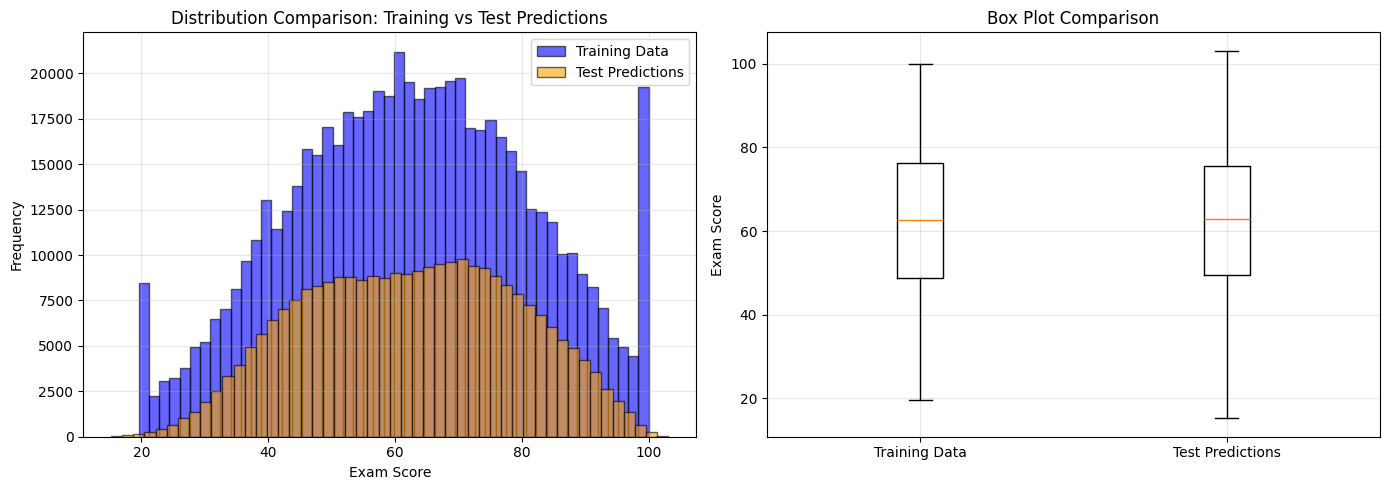


Training Data - Mean: 62.51, Std: 18.92
Test Predictions - Mean: 62.52, Std: 16.76


In [24]:
# Prediction distribution comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(train_data['exam_score'], bins=50, alpha=0.6, label='Training Data', color='blue', edgecolor='black')
plt.hist(test_predictions, bins=50, alpha=0.6, label='Test Predictions', color='orange', edgecolor='black')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.title('Distribution Comparison: Training vs Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([train_data['exam_score'], test_predictions], labels=['Training Data', 'Test Predictions'])
plt.ylabel('Exam Score')
plt.title('Box Plot Comparison')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Data - Mean: {train_data['exam_score'].mean():.2f}, Std: {train_data['exam_score'].std():.2f}")
print(f"Test Predictions - Mean: {test_predictions.mean():.2f}, Std: {test_predictions.std():.2f}")

In [25]:
# 15. Save the submission file
submission.to_csv('submission.csv', index=False)

print('Submission file created successfully!')

Submission file created successfully!
